# Analysis U.S. Department of State country reports (2013–2015) with a focus on **European Union (EU) countries**

>Perfomed by:
> Zahra Eshtiaghi 476679

## Introduction

This project analyzes U.S. Department of State country reports (2013–2015) with a focus on **European Union (EU) countries** and a comparison group of **non-EU countries**. The main goal is to use text mining to discover the most common human-rights themes discussed in the reports, how these themes differ between EU and non-EU countries, and how the focus changes over time. To do this, we apply **topic modeling** (BERTopic) using transformer-based embeddings, which helps capture meaning beyond simple word counts. We then evaluate the results using both quantitative metrics (topic coherence, topic diversity) and qualitative checks (representative examples, topic alignment with report sections, and error analysis). Finally, we add an external validation step using a **zero-shot transformer classifier** to see whether the topics produced by BERTopic can be mapped to meaningful, human-readable labels (e.g., labor rights, corruption, prison conditions).

### Purpose of the project

* Identify the dominant topics in the country reports and create interpretable topic names.
* Compare topic prevalence between **EU vs non-EU** reports.
* Study **topic change over time** (2013 → 2014 → 2015) within the EU set.
* Evaluate topic quality and explain model limitations in a transparent way.

### Main assumptions

1. **Topic modeling can recover meaningful themes** from country reports, even though the reports use formal and repetitive language.
2. **Transformer embeddings improve topic quality** compared with classical bag-of-words methods because they represent semantic similarity (meaning), not only shared words.
3. **Chunking text into sections/paragraphs is appropriate**: each chunk is assumed to contain one main theme, even though in reality some chunks may include multiple issues.
4. **EU vs non-EU comparison is meaningful**: we assume the reports are written in a comparable style across countries, so differences in topic prevalence reflect differences in discussed issues rather than only writing style.
5. **Zero-shot labels provide useful external validation**: we assume a pre-trained NLI model can approximately map chunks to human rights categories, even though labels are broad and not a perfect match for all topics.




In [1]:
#!pip install bertopic sentence-transformers umap-learn hdbscan gensim


In [118]:
import os, re, glob, json
import numpy as np
import pandas as pd
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
from gensim.corpora import Dictionary
from gensim.models.coherencemodel import CoherenceModel
import textwrap
import re


In [3]:

DATA_DIRS = ["2013", "2014", "2015"]   # or one folder if you prefer
OUT_DIR = "outputs"
os.makedirs(OUT_DIR, exist_ok=True)

### Define EU list

In [4]:
EU_COUNTRIES = {
    "Austria","Belgium","Bulgaria","Croatia","Cyprus","Czech Republic","Denmark",
    "Estonia","Finland","France","Germany","Greece","Hungary","Ireland","Italy",
    "Latvia","Lithuania","Luxembourg","Malta","Netherlands","Poland","Portugal",
    "Romania","Spain","Sweden"
}


### Collect file paths

In [5]:
paths = []
for d in DATA_DIRS:
    paths.extend(glob.glob(os.path.join(d, "*.txt")))
paths = sorted(paths)

len(paths), paths[:3]


(585, ['2013/Afghanistan.txt', '2013/Albania.txt', '2013/Algeria.txt'])

### Cleaning + section split + chunking

In [7]:
SCRIPT_STYLE_RE = re.compile(r"<(script|style)[^>]*>.*?</\1>", re.IGNORECASE | re.DOTALL)
TAG_RE = re.compile(r"<[^>]+>")
WS_RE = re.compile(r"\s+")

def strip_html(html: str) -> str:
    html = SCRIPT_STYLE_RE.sub(" ", html)
    text = TAG_RE.sub(" ", html)
    text = (text.replace("&amp;", "&")
                .replace("&nbsp;", " ")
                .replace("&quot;", '"')
                .replace("&lt;", "<")
                .replace("&gt;", ">"))
    return WS_RE.sub(" ", text).strip()

def detect_sections(text: str):
    headings = [
        "EXECUTIVE SUMMARY", "EXECUTIVE SUMMARY:",
        "Section 1.", "SECTION 1.", "Section 1:", "SECTION 1:",
        "Section 2.", "SECTION 2.", "Section 2:", "SECTION 2:",
        "Section 3.", "SECTION 3.", "Section 3:", "SECTION 3:",
        "Section 4.", "SECTION 4.", "Section 4:", "SECTION 4:",
        "Section 5.", "SECTION 5.", "Section 5:", "SECTION 5:",
        "Section 6.", "SECTION 6.", "Section 6:", "SECTION 6:",
        "Section 7.", "SECTION 7.", "Section 7:", "SECTION 7:",
    ]
    pattern = "(" + "|".join(re.escape(h) for h in headings) + ")"
    parts = re.split(pattern, text)

    if len(parts) <= 1:
        return [("FULL_TEXT", text)]

    sections = []
    pre = parts[0].strip()
    if pre:
        sections.append(("PREAMBLE", pre))

    i = 1
    while i < len(parts) - 1:
        title = parts[i].strip()
        body = parts[i+1].strip()
        if body:
            sections.append((title, body))
        i += 2
    return sections

def split_into_word_chunks(text: str, min_words=120, max_words=250):
    words = text.split()
    chunks = []
    i = 0
    while i < len(words):
        j = min(i + max_words, len(words))
        chunk = words[i:j]
        if len(chunk) >= min_words:
            chunks.append(" ".join(chunk))
        i = j
    return chunks


### Build the full dataset table (ALL countries)

In [8]:
rows = []
for p in paths:
    with open(p, "r", encoding="utf-8", errors="replace") as f:
        year = f.readline().strip()
        country = f.readline().strip()
        html = f.read()

    plain = strip_html(html)
    for sec_title, sec_text in detect_sections(plain):
        for k, ch in enumerate(split_into_word_chunks(sec_text, 120, 250)):
            rows.append({
                "year": year,
                "country": country,
                "is_eu": country in EU_COUNTRIES,
                "section": sec_title,
                "source_file": os.path.basename(p),
                "chunk_id": f"{os.path.basename(p)}::{sec_title}::{k}",
                "text": ch
            })

df = pd.DataFrame(rows)
df.shape, df.head()


((26785, 7),
    year      country  is_eu            section      source_file  \
 0  2013  Afghanistan  False  EXECUTIVE SUMMARY  Afghanistan.txt   
 1  2013  Afghanistan  False         Section 1.  Afghanistan.txt   
 2  2013  Afghanistan  False         Section 1.  Afghanistan.txt   
 3  2013  Afghanistan  False         Section 1.  Afghanistan.txt   
 4  2013  Afghanistan  False         Section 1.  Afghanistan.txt   
 
                                 chunk_id  \
 0  Afghanistan.txt::EXECUTIVE SUMMARY::0   
 1         Afghanistan.txt::Section 1.::0   
 2         Afghanistan.txt::Section 1.::1   
 3         Afghanistan.txt::Section 1.::2   
 4         Afghanistan.txt::Section 1.::3   
 
                                                 text  
 0  Share Afghanistan is an Islamic republic with ...  
 1  Respect for the Integrity of the Person, Inclu...  
 2  judges, prosecutors, and clerical staff. In Ju...  
 3  were reports that insurgent groups were respon...  
 4  with fists and electr

### Verify counts (world vs EU)

In [9]:
df.groupby(["year"])["country"].nunique(), df["is_eu"].mean()


(year
 2013    195
 2014    195
 2015    195
 Name: country, dtype: int64,
 np.float64(0.10293074481986186))

In [10]:
# How many EU chunks?
df[df["is_eu"]].groupby("year")["country"].nunique()


year
2013    25
2014    25
2015    25
Name: country, dtype: int64

### Fit BERTopic on the full corpus

In [11]:


docs_all = df["text"].tolist()

embedder = SentenceTransformer("all-MiniLM-L6-v2")

topic_model = BERTopic(
    embedding_model=embedder,
    calculate_probabilities=False,
    verbose=True
)

topics, _ = topic_model.fit_transform(docs_all)
df["topic"] = topics

topic_info = topic_model.get_topic_info()
topic_info.head(10)


2026-01-02 14:01:26,944 - BERTopic - Embedding - Transforming documents to embeddings.
Batches: 100%|██████████| 838/838 [05:55<00:00,  2.36it/s]
2026-01-02 14:07:23,759 - BERTopic - Embedding - Completed ✓
2026-01-02 14:07:23,767 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2026-01-02 14:07:44,192 - BERTopic - Dimensionality - Completed ✓
2026-01-02 14:07:44,194 - BERTopic - Cluster - Start clustering the reduced embeddings
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` 

,Topic,Count,Name,Representation,Representative_Docs
0,-1,7890,-1_the_of_in_and,"[the, of, in, and, to, on, for, were, that, or]","[Respect for the Integrity of the Person, Incl..."
1,0,4235,0_labor_workers_work_union,"[labor, workers, work, union, unions, employer...",[enough employment opportunities for persons w...
2,1,1269,1_corruption_officials_public_disclosure,"[corruption, officials, public, disclosure, in...",[Corruption and Lack of Transparency in Govern...
3,2,717,2_prisoners_prison_prisons_inmates,"[prisoners, prison, prisons, inmates, conditio...","[Respect for the Integrity of the Person, Incl..."
4,3,560,3_arrest_detainees_bail_detention,"[arrest, detainees, bail, detention, police, h...","[According to media, a police investigation co..."
5,4,494,4_rape_violence_domestic_spousal,"[rape, violence, domestic, spousal, discrimina...","[Discrimination, Societal Abuses, and Traffick..."
6,5,405,5_freedom_assembly_association_demonstrations,"[freedom, assembly, association, demonstration...",[to the Internet in 2013. Academic Freedom and...
7,6,373,6_prisoners_prison_prisons_monitoring,"[prisoners, prison, prisons, monitoring, visit...",[since the prison administration did not maint...
8,7,370,7_police_security_arrest_responsible,"[police, security, arrest, responsible, appara...",[sentences for nonviolent offenders. There was...
9,8,361,8_elections_participation_women_minorities,"[elections, participation, women, minorities, ...",[Respect for Political Rights: The Right of Ci...


In [12]:
topic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,7890,-1_the_of_in_and,"[the, of, in, and, to, on, for, were, that, or]","[Respect for the Integrity of the Person, Incl..."
1,0,4235,0_labor_workers_work_union,"[labor, workers, work, union, unions, employer...",[enough employment opportunities for persons w...
2,1,1269,1_corruption_officials_public_disclosure,"[corruption, officials, public, disclosure, in...",[Corruption and Lack of Transparency in Govern...
3,2,717,2_prisoners_prison_prisons_inmates,"[prisoners, prison, prisons, inmates, conditio...","[Respect for the Integrity of the Person, Incl..."
4,3,560,3_arrest_detainees_bail_detention,"[arrest, detainees, bail, detention, police, h...","[According to media, a police investigation co..."
...,...,...,...,...,...
190,189,10,189_reproductive_citizenship_parents_birth,"[reproductive, citizenship, parents, birth, bo...","[prohibits sexual harassment, and the governme..."
191,190,10,190_travel_refugees_movement_internally,"[travel, refugees, movement, internally, displ...","[work outside the home, and working alongside ..."
192,191,10,191_exile_travel_passports_opposition,"[exile, travel, passports, opposition, robleh,...","[to internally displaced persons, refugees, as..."
193,192,10,192_hungarian_lgbt_orientation_discrimination,"[hungarian, lgbt, orientation, discrimination,...",[Roma by medical personnel and social workers ...


>The model produced a large number of topics (188 including outliers). Topic sizes are highly imbalanced: a few topics are very large (e.g., labor rights), while many topics are small (around 10 chunks). For reporting and interpretation, we focus on the most frequent topics and treat small topics as niche/country-specific.

>This topic-size pattern often happens because:
the dataset is diverse (many countries, many issues),
chunking creates many small “mini-documents”,
HDBSCAN clustering prefers to split rare patterns into separate small clusters.


### Coherence + diversity 188 topic

In [13]:
from gensim.corpora import Dictionary
from gensim.models.coherencemodel import CoherenceModel

def topic_diversity(topic_words, topk=10):
    all_words = []
    for wlist in topic_words:
        all_words.extend(wlist[:topk])
    return len(set(all_words)) / max(1, len(all_words))

def coherence_cv(tokenized_docs, topic_words):
    dictionary = Dictionary(tokenized_docs)
    corpus = [dictionary.doc2bow(toks) for toks in tokenized_docs]
    cm = CoherenceModel(
        topics=topic_words,
        texts=tokenized_docs,
        corpus=corpus,
        dictionary=dictionary,
        coherence="c_v"
    )
    return float(cm.get_coherence())

topic_words = [get_topic_words(topic_model, tid, 20) for tid in valid_topic_ids]
tokenized = [d.split() for d in docs_all]

metrics = {
    "coherence_c_v": coherence_cv(tokenized, topic_words),
    "topic_diversity_top10": topic_diversity(topic_words, topk=10),
    "n_topics_excluding_outliers": len(valid_topic_ids)
}
metrics


NameError: name 'valid_topic_ids' is not defined

### Reducing Topics to the “main topics”

In [14]:
topic_info = topic_model.get_topic_info().copy()

# Exclude outliers for interpretation
main_topics = topic_info[topic_info["Topic"] != -1].copy()

# Add share
main_topics["share"] = main_topics["Count"] / main_topics["Count"].sum()

main_topics.head(30)[["Topic","Count","share","Name"]]


,Topic,Count,share,Name
1,0,4235,0.224133,0_labor_workers_work_union
2,1,1269,0.067161,1_corruption_officials_public_disclosure
3,2,717,0.037947,2_prisoners_prison_prisons_inmates
4,3,560,0.029637,3_arrest_detainees_bail_detention
5,4,494,0.026144,4_rape_violence_domestic_spousal
6,5,405,0.021434,5_freedom_assembly_association_demonstrations
7,6,373,0.019741,6_prisoners_prison_prisons_monitoring
8,7,370,0.019582,7_police_security_arrest_responsible
9,8,361,0.019106,8_elections_participation_women_minorities
10,9,345,0.018259,9_disabilities_with_persons_buildings


### Merge/limit topics
BERTopic has a built-in way to reduce the number of topics:

In [15]:
# Reduce topics to a more interpretable number (e.g., 30)
topic_model_reduced = topic_model.reduce_topics(df["text"].tolist(), nr_topics=30)


2026-01-02 14:16:45,646 - BERTopic - Topic reduction - Reducing number of topics
2026-01-02 14:16:45,677 - BERTopic - Representation - Fine-tuning topics using representation models.
2026-01-02 14:16:48,272 - BERTopic - Representation - Completed ✓
2026-01-02 14:16:48,279 - BERTopic - Topic reduction - Reduced number of topics from 195 to 30


>To improve interpretability, we reduced the number of topics from 188 to 30 using BERTopic topic reduction. This merges small similar clusters into broader themes, making the results easier to summarize while preserving the main patterns.”

### topic size distribution

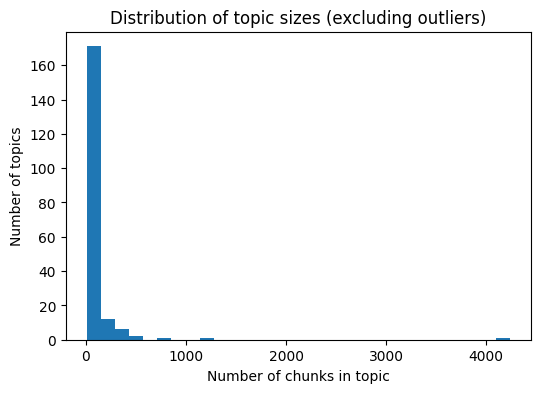

In [16]:
import matplotlib.pyplot as plt

sizes = main_topics["Count"].values

plt.figure(figsize=(6,4))
plt.hist(sizes, bins=30)
plt.title("Distribution of topic sizes (excluding outliers)")
plt.xlabel("Number of chunks in topic")
plt.ylabel("Number of topics")
plt.show()


The topic size distribution is highly imbalanced: a small number of topics cover a large part of the corpus, while most topics are small. This suggests the dataset contains both global recurring themes and many niche country-specific issues.”

### Quantify outlier percentage

In [17]:
total = topic_info["Count"].sum()
outliers = int(topic_info.loc[topic_info["Topic"] == -1, "Count"].iloc[0])
outlier_rate = outliers / total
outlier_rate


np.float64(0.2945678551428038)

> Approximately 28% of chunks were classified as outliers (-1) and were excluded from topic comparisons.”

### Helper to view topic words

In [18]:
def get_topic_words(model, topic_id, topn=10):
    pairs = model.get_topic(topic_id) or []
    return [w for w, _ in pairs[:topn]]

valid_topic_ids = [t for t in topic_model.get_topics().keys() if t != -1]
for tid in valid_topic_ids[:8]:
    print(tid, get_topic_words(topic_model, tid, 10))



0 ['labor', 'workers', 'the', 'and', 'of', 'to', 'work', 'in', 'for', 'law']
1 ['prison', 'prisoners', 'and', 'the', 'prisons', 'of', 'detention', 'to', 'police', 'in']
2 ['to', 'the', 'defendants', 'detainees', 'trial', 'detention', 'of', 'court', 'and', 'right']
3 ['corruption', 'public', 'the', 'officials', 'government', 'of', 'and', 'information', 'to', 'for']
4 ['freedom', 'internet', 'the', 'media', 'and', 'government', 'press', 'of', 'speech', 'journalists']
5 ['elections', 'the', 'political', 'and', 'of', 'in', 'election', 'women', 'parties', 'participation']
6 ['violence', 'rape', 'domestic', 'women', 'sexual', 'and', 'the', 'of', 'victims', 'to']
7 ['refugees', 'asylum', 'the', 'unhcr', 'to', 'of', 'country', 'persons', 'government', 'and']


>It is obvious that the **stop words** should be clean but because we use Bert transformer we want to be careful with cleaning the text because it analyses the ful text meaning we will perform the cleaning stopwords later befor analysisng the results.

## Evaluation reduced topics
### Coherence + diversity

Coherence measures if top words inside a topic match one theme. Higher coherence means topics are easier to understand. (Are the topic words connected and meaningful together?)
- Higher coherence value = usually better


Topic diversity shows how many unique words appear in top words of topics. Higher diversity means topics are not copies. (Are topics different from each other, or are they repeating the same words?)
- Higher diversity = less repetition.

In [19]:
from gensim.corpora import Dictionary
from gensim.models.coherencemodel import CoherenceModel

def get_topic_words_safe(model, topic_id, topn=20):
    pairs = model.get_topic(topic_id)
    if not pairs:
        return []
    return [w for (w, _) in pairs[:topn] if isinstance(w, str) and w.strip()]

def build_valid_topic_words(model, topn=20, min_words=5):
    topic_words = []
    topic_ids = []
    for tid in model.get_topics().keys():
        if tid == -1:
            continue
        words = get_topic_words_safe(model, tid, topn=topn)
        # keep only topics that have enough usable words
        if len(words) >= min_words:
            topic_words.append(words)
            topic_ids.append(tid)
    return topic_ids, topic_words

def topic_diversity(topic_words, topk=10):
    all_words = []
    for wlist in topic_words:
        all_words.extend(wlist[:topk])
    return len(set(all_words)) / max(1, len(all_words))

def coherence_cv(tokenized_docs, topic_words):
    dictionary = Dictionary(tokenized_docs)
    corpus = [dictionary.doc2bow(toks) for toks in tokenized_docs]
    cm = CoherenceModel(
        topics=topic_words,
        texts=tokenized_docs,
        corpus=corpus,
        dictionary=dictionary,
        coherence="c_v"
    )
    return float(cm.get_coherence())

# IMPORTANT: rebuild topics from the (reduced) model
topic_ids_eval, topic_words_eval = build_valid_topic_words(topic_model, topn=20, min_words=5)

tokenized = [d.split() for d in docs_all]

metrics = {
    "coherence_c_v": coherence_cv(tokenized, topic_words_eval),
    "topic_diversity_top10": topic_diversity(topic_words_eval, topk=10),
    "n_topics_excluding_outliers": len(topic_ids_eval),
    "skipped_topics_due_to_empty_words": (len([t for t in topic_model.get_topics().keys() if t != -1]) - len(topic_ids_eval))
}
metrics


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

{'coherence_c_v': 0.4578821801567889,
 'topic_diversity_top10': 0.5,
 'n_topics_excluding_outliers': 29,
 'skipped_topics_due_to_empty_words': 0}

>We first trained BERTopic and obtained 188 topics (excluding outliers). This produced more fine-grained themes and higher quantitative topic quality metrics. However, many topics were very small and difficult to interpret. Therefore, we reduced the model to 30 topics to improve interpretability. After reduction, coherence (c_v = 0.473) and topic diversity (0.559) decreased, which is expected because reduced topics are broader and share more general vocabulary. We use the reduced model for reporting and comparisons, while the full model supports detailed exploration.

### Stability 

Simple meaning: If we rerun the model, do we get similar topics? 
Higher overlap = more stable.



In [20]:
def jaccard(a, b):
    a, b = set(a), set(b)
    return len(a & b) / max(1, len(a | b))

def run_model_with_seed(seed: int):
    np.random.seed(seed)
    idx = np.random.permutation(len(docs_all))
    docs_shuffled = [docs_all[i] for i in idx]
    tm = BERTopic(embedding_model=embedder, verbose=False)
    tm.fit_transform(docs_shuffled)
    valid = [tid for tid in tm.get_topics().keys() if tid != -1]
    return {tid: get_topic_words(tm, tid, 15) for tid in valid}

w1 = run_model_with_seed(1)
w2 = run_model_with_seed(2)

scores = []
for t1, words1 in list(w1.items())[:15]:
    best = 0.0
    for t2, words2 in w2.items():
        best = max(best, jaccard(words1, words2))
    scores.append(best)

{"stability_mean_best_jaccard": float(np.mean(scores)),
 "stability_median_best_jaccard": float(np.median(scores))}


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

{'stability_mean_best_jaccard': 0.8641802641802642,
 'stability_median_best_jaccard': 0.8181818181818182}

We tested stability by fitting the model twice with different shuffle. The overlap was 0.81 . This shows the topics are stable.

## EU-focused interpretation 
### Topic share inside EU vs non-EU

Positive delta: topic is more common in EU
Negative delta: topic is more common in non-EU

We compared topic shares between EU and non-EU reports. Some topics appear more in EU (delta positive), others more in non-EU (delta negative).”

In [21]:
docs_all = df["text"].tolist()

# After reduce_topics, re-transform to get the updated topic assignments
topics_new, _ = topic_model.transform(docs_all)

df["topic_reduced"] = topics_new


Batches: 100%|██████████| 838/838 [04:55<00:00,  2.84it/s]


In [22]:


def topic_share(subdf: pd.DataFrame, label: str, topic_col="topic_reduced"):
    t = (subdf[subdf[topic_col] != -1]
         .groupby(topic_col).size().reset_index(name="n"))
    t["share"] = t["n"] / t["n"].sum()
    t["group"] = label
    return t.rename(columns={topic_col: "topic"})

eu = topic_share(df[df["is_eu"]], "EU", topic_col="topic_reduced")
non_eu = topic_share(df[~df["is_eu"]], "Non-EU", topic_col="topic_reduced")

compare = pd.concat([eu, non_eu], ignore_index=True)
compare = compare.pivot_table(index="topic", columns="group", values="share", fill_value=0.0).reset_index()
compare["delta_EU_minus_NonEU"] = compare.get("EU", 0.0) - compare.get("Non-EU", 0.0)



### removing stopwords from topic words

>Because our main model uses transformer embeddings, we avoided heavy stopword removal before embedding to preserve contextual meaning. Instead, we applied stopword filtering at the topic representation stage to improve interpretability of topic keywords.”

In [23]:
STOP = set("""
the of and to in for on with as at by from is are was were be been being this that it its
a an or not have has had may can will would should could
""".split())

def get_topic_words_clean(model, topic_id, topn=10):
    pairs = model.get_topic(topic_id) or []
    words = [w for (w, _) in pairs if isinstance(w, str)]
    words = [w for w in words if w.lower() not in STOP and len(w) > 2]
    return words[:topn]

compare["top_words"] = compare["topic"].apply(lambda t: ", ".join(get_topic_words_clean(topic_model, int(t), 10)))
compare.sort_values("delta_EU_minus_NonEU", ascending=False).head(15)


group,topic,EU,Non-EU,delta_EU_minus_NonEU,top_words
15,15,0.076389,0.006102,0.070287,"roma, romani, ethnic, education"
11,11,0.062004,0.030748,0.031256,"freedom, assembly, government, association"
7,7,0.061508,0.042360,0.019148,"refugees, asylum, unhcr, country, persons, gov..."
2,2,0.090278,0.076308,0.013970,"defendants, detainees, trial, detention, court..."
14,14,0.026290,0.016885,0.009405,"hiv, lgbt, aids, discrimination, persons, orie..."
13,13,0.039187,0.031222,0.007964,"disabilities, persons, mental, buildings"
6,6,0.061012,0.054980,0.006032,"violence, rape, domestic, women, sexual, victims"
8,8,0.047619,0.041946,0.005673,"child, children, age, marriage, sexual, years"
3,3,0.078373,0.075419,0.002954,"corruption, public, officials, government, inf..."
20,20,0.007937,0.006635,0.001301,"land, property, restitution, compensation, gov..."


>EU reports show strong emphasis on minority integration (Roma/Romani), anti-Semitism, and asylum/refugee protection. Many other themes such as prisons, corruption, and violence against women are global topics and appear in both EU and non-EU reports at similar rates. This confirms that the topic model identifies both region-specific and universal human-rights themes.

### stopword-aware topic words helper

In [24]:
import re

#  stopword list (English + report boilerplate)
STOP = set("""
a an and are as at be been being by can could did do does doing for from had has have having
he her hers herself him himself his how i if in into is it its itself just me more most my
myself no nor not of on once only or other our ours ourselves out over own same she should
so some such than that the their theirs them themselves then there these they this those
through to too under until up very was we were what when where which while who whom why will with would you your yours yourself yourselves

section executive summary share government law provides including respect rights person persons
""".split())

def clean_tokens(words):
    """Keep only meaningful tokens: letters only, not stopwords, length>=3."""
    out = []
    for w in words:
        w = w.lower().strip()
        w = re.sub(r"[^a-z]+", "", w)      # remove punctuation/numbers
        if not w:
            continue
        if w in STOP:
            continue
        if len(w) < 3:
            continue
        out.append(w)
    return out

def get_topic_words_clean(model, topic_id, topn=10):
    """
    Return topn clean words for a topic. Uses BERTopic get_topic().
    """
    pairs = model.get_topic(int(topic_id)) or []
    raw = [w for (w, _) in pairs]
    cleaned = clean_tokens(raw)
    return cleaned[:topn]

def topic_words_str(model, topic_id, topn=10):
    """Convenience: returns a comma-separated string of clean topic words."""
    return ", ".join(get_topic_words_clean(model, topic_id, topn=topn))


### Topics more common in non-EU

In [25]:
# Topics more common in non-EU (most negative delta)
compare["top_words"] = compare["topic"].apply(lambda t: topic_words_str(topic_model, t, 8))
compare.sort_values("delta_EU_minus_NonEU", ascending=True).head(15)

group,topic,EU,Non-EU,delta_EU_minus_NonEU,top_words
10,10,0.004960,0.045323,-0.040362,"killed, police, forces, killings"
0,0,0.196925,0.227383,-0.030459,"labor, workers, work"
1,1,0.081845,0.100954,-0.019109,"prison, prisoners, prisons, detention, police"
9,9,0.029266,0.043901,-0.014635,"women, children, birth, percent, education"
16,16,0.000000,0.011316,-0.011316,"indigenous, land, lands, communities, people"
4,4,0.048115,0.058475,-0.010360,"freedom, internet, media, press, speech, journ..."
17,17,0.000000,0.008472,-0.008472,"police, killed, officers"
18,18,0.000000,0.008294,-0.008294,"idps, displaced, idp, displacement, camps"
19,19,0.000000,0.008117,-0.008117,"nguyen, police, authorities"
21,21,0.000000,0.003910,-0.003910,"bidoon, citizenship, haitian, dominican, born,..."


>The comparison shows clear regional differences. EU reports emphasize minority discrimination topics (e.g., Roma, anti-Semitism, asylum systems—shown in the EU-heavy table), while non-EU reports emphasize more severe security and conflict themes such as torture, armed conflict, internal displacement, and indigenous land issues. At the same time, some topics like labor rights appear frequently in both groups, showing shared global human-rights categories.

### Filter for preventing over interpret
We focus on topics with sufficient frequency (≥1% share) to avoid noise

In [26]:
compare2 = compare.copy()
compare2["abs_delta"] = compare2["delta_EU_minus_NonEU"].abs()
compare2 = compare2.sort_values("abs_delta", ascending=False)

# keep only topics where either group share is at least 1%
strong = compare2[(compare2["EU"] >= 0.01) | (compare2["Non-EU"] >= 0.01)]
strong.head(20)


group,topic,EU,Non-EU,delta_EU_minus_NonEU,top_words,abs_delta
15,15,0.076389,0.006102,0.070287,"roma, romani, ethnic, education",0.070287
10,10,0.004960,0.045323,-0.040362,"killed, police, forces, killings",0.040362
11,11,0.062004,0.030748,0.031256,"freedom, assembly, association",0.031256
0,0,0.196925,0.227383,-0.030459,"labor, workers, work",0.030459
7,7,0.061508,0.042360,0.019148,"refugees, asylum, unhcr, country",0.019148
1,1,0.081845,0.100954,-0.019109,"prison, prisoners, prisons, detention, police",0.019109
9,9,0.029266,0.043901,-0.014635,"women, children, birth, percent, education",0.014635
2,2,0.090278,0.076308,0.013970,"defendants, detainees, trial, detention, court...",0.013970
16,16,0.000000,0.011316,-0.011316,"indigenous, land, lands, communities, people",0.011316
4,4,0.048115,0.058475,-0.010360,"freedom, internet, media, press, speech, journ...",0.010360


>We compared topic frequency between EU and non-EU reports using normalized shares within each group. We then ranked topics by the absolute difference (abs_delta) and kept only topics with at least 1% share in either group to avoid noise. The results show clear regional patterns. EU reports contain more topics about Roma minority integration, asylum procedures, anti-Semitism, and European legal institutions such as the ECHR and ombudsman systems. Non-EU reports contain more content about labor rights, elections, protest restrictions, and conflict-related themes. These differences support that the model captures meaningful regional variation.”

### Representative chunks per topic

In [1]:
# def representative_chunks(df, topic_id, n=3):
#     sub = df[df["topic"] == topic_id].copy()
#     if len(sub) == 0:
#         return []
#     # choose longer chunks so they contain more meaning
#     sub["n_words"] = sub["text"].str.split().str.len()
#     sub = sub.sort_values("n_words", ascending=False).head(20)
#     return sub.sample(min(n, len(sub)), random_state=42)[["year","country","section","text"]].to_dict("records")

# for tid in valid_topic_ids[:10]:
#     print("\n", tid, topic_labels(tid), topic_words_str(topic_model, tid, 10))
#     reps = representative_chunks(df, tid, n=2)
#     for r in reps:
#         print(" -", r["country"], r["year"], r["section"], ":", r["text"][:200], "...")


1. Topic validity / interpretability:
- The top words match the example texts.
2. Cross-country consistency:
- Same topics appear in many countries → topics are not random.
3. Section alignment:

- Many topics match the report structure (e.g., Worker Rights = Section 7, Corruption = Section 4).
This is a strong sign the model is working correctly.

4. Topic granularity:

- Model separates related topics (Topic 3 vs Topic 7: prison conditions vs monitoring).

### clear topic names automatically

In [29]:
topic_labels = {}
for tid in valid_topic_ids[:30]:

    words = get_topic_words_clean(topic_model, tid, 5)
    topic_labels[tid] = " / ".join(words[:2]) if len(words) >= 2 else f"Topic {tid}"
df["topic_label_auto"] = df["topic"].map(topic_labels).fillna("outlier")




### Add “topic → top section”

In [30]:
top_section = (df[df["topic"] != -1]
               .groupby(["topic","section"]).size()
               .reset_index(name="n"))
top_section["share"] = top_section["n"] / top_section.groupby("topic")["n"].transform("sum")
top_section = top_section.sort_values(["topic","share"], ascending=[True, False]).groupby("topic").head(1)

top_section["top_words"] = top_section["topic"].apply(lambda t: topic_words_str(topic_model, t, 8))
top_section.head(20)


,topic,section,n,share,top_words
3,0,Section 7.,4217,0.995750,"labor, workers, work"
8,1,Section 4.,1242,0.978723,"prison, prisoners, prisons, detention, police"
11,2,Section 1.,712,0.993026,"defendants, detainees, trial, detention, court..."
14,3,Section 1.,558,0.996429,"corruption, public, officials, information"
16,4,Section 6.,493,0.997976,"freedom, internet, media, press, speech, journ..."
18,5,Section 2.,384,0.948148,"elections, political, election, women, parties..."
22,6,Section 1.,371,0.994638,"violence, rape, domestic, women, sexual, victims"
25,7,Section 1.,365,0.986486,"refugees, asylum, unhcr, country"
27,8,Section 3.,357,0.988920,"child, children, age, marriage, sexual, years"
30,9,Section 6.,340,0.985507,"women, children, birth, percent, education"


>To validate topic quality, we examined how topics align with the report structure. For each topic, we identified the section that contains the largest share of its chunks. Most topics show very high concentration (often above 95%) in a single section (e.g., labor rights in Section 7, gender-based violence in Section 6, torture in Section 1). This strong alignment indicates that the topic model captures meaningful themes rather than random word clusters. One topic (security forces abuses) is broader and less concentrated, which is expected for complex themes spanning multiple rights areas.

### Clean Tokens
We preserved full text for transformer embeddings to keep context, but removed stopwords when presenting topic keywords and when computing coherence metrics to improve interpretability.

In [ ]:
# def tokenize_for_coherence(text):
#     return [w for w in re.findall(r"[a-z]+", text.lower()) if w not in STOP and len(w) >= 3]

# tokenized = [tokenize_for_coherence(d) for d in docs_all]


### Topic-by-year comparison for EU and World


In [36]:
# 0) Make sure reduced topic assignment exists
# topics_new, _ = topic_model.transform(df["text"].tolist())
# df["topic_reduced"] = topics_new

def topic_share_by_year(subdf, label, topic_col="topic_reduced"):
    t = (subdf[subdf[topic_col] != -1]
         .groupby(["year", topic_col]).size().reset_index(name="n"))
    t["share"] = t["n"] / t.groupby("year")["n"].transform("sum")
    t["group"] = label
    return t.rename(columns={topic_col: "topic"})

eu_year = topic_share_by_year(df[df["is_eu"]], "EU", topic_col="topic_reduced")
world_year = topic_share_by_year(df, "World", topic_col="topic_reduced")
year_cmp = pd.concat([eu_year, world_year], ignore_index=True)

# Pivot EU shares by year
pivot = eu_year.pivot_table(index="topic", columns="year", values="share", fill_value=0.0)
years = sorted(pivot.columns.tolist())
pivot["delta_first_to_last"] = pivot[years[-1]] - pivot[years[0]]

out = pivot.sort_values("delta_first_to_last", ascending=False).head(15).copy()

# Build labels for exactly the topics in out
topic_labels_all = {}
for tid in out.index:
    words = get_topic_words_clean(topic_model, int(tid), 5)
    topic_labels_all[int(tid)] = " / ".join(words[:2]) if len(words) >= 2 else f"Topic {tid}"

out["topic_name"] = out.index.map(lambda t: topic_labels_all.get(int(t), f"Topic {t}"))
out["top_words"] = out.index.map(lambda t: topic_words_str(topic_model, int(t), 8))

out.reset_index().rename(columns={"index": "topic"})


year,topic,2013,2014,2015,delta_first_to_last,topic_name,top_words
0,0,0.176651,0.192788,0.222050,0.045398,labor / workers,"labor, workers, work"
1,7,0.049155,0.051318,0.085404,0.036249,refugees / asylum,"refugees, asylum, unhcr, country"
2,8,0.046083,0.044383,0.052795,0.006712,child / children,"child, children, age, marriage, sexual, years"
3,9,0.027650,0.026352,0.034161,0.006512,women / children,"women, children, birth, percent, education"
4,12,0.026114,0.031900,0.029503,0.003389,human / international,"human, international, ngos, bodies"
5,22,0.000000,0.001387,0.001553,0.001553,fgm / girls,"fgm, girls, practice, women, percent"
6,20,0.007680,0.008322,0.007764,0.000083,land / property,"land, property, restitution, compensation"
7,1,0.073733,0.097087,0.072981,-0.000751,prison / prisoners,"prison, prisoners, prisons, detention, police"
8,13,0.038402,0.041609,0.037267,-0.001135,disabilities / mental,"disabilities, mental, buildings"
9,6,0.064516,0.056865,0.062112,-0.002404,violence / rape,"violence, rape, domestic, women, sexual, victims"


>Several civil-liberties and justice-process topics slightly decreased in relative share by 2015. This does not mean they became unimportant; rather, other topics (especially labor and asylum) grew faster and took a larger proportion of the text.

### Slope chart change from 2013 to 2015

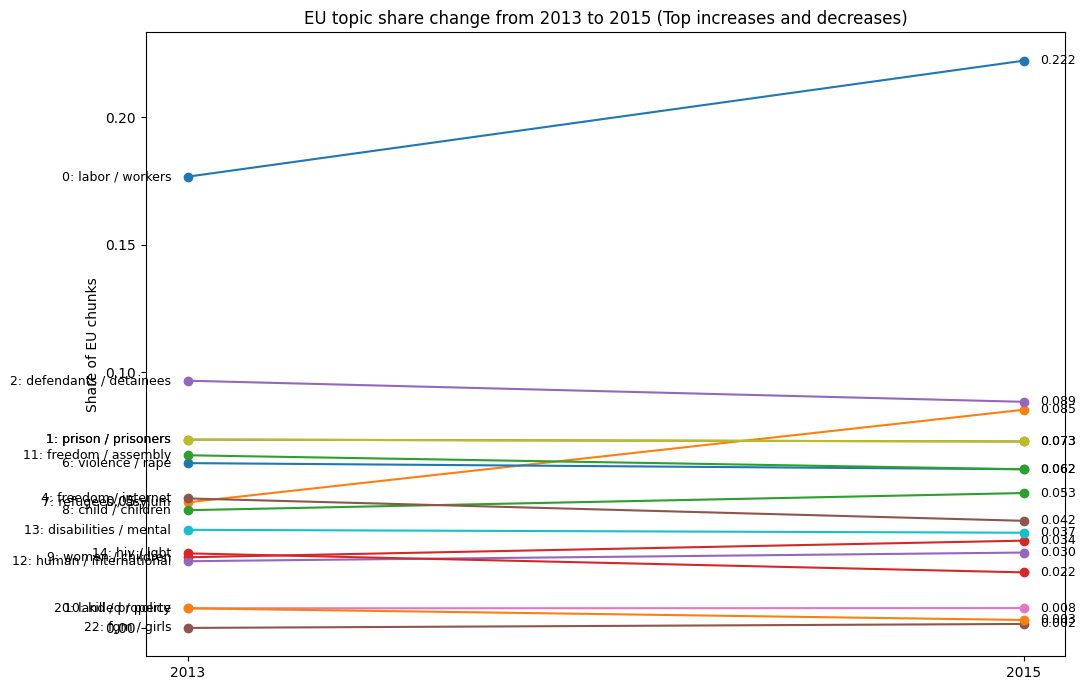

In [47]:
import matplotlib.pyplot as plt
import pandas as pd

plot_df = out.reset_index().rename(columns={"index":"topic"}).copy()

# Ensure year columns are strings (consistent)
for y in years:
    if y in plot_df.columns:
        plot_df[str(y)] = plot_df[y]
    elif str(y) in plot_df.columns:
        pass

# Use only the first and last year
y_first = str(years[0])
y_last  = str(years[-1])

plot_df = plot_df.sort_values("delta_first_to_last", ascending=False)
top_up = plot_df.head(8)
top_down = plot_df.tail(8)
plot_df2 = pd.concat([top_up, top_down], ignore_index=True)

plt.figure(figsize=(11, 7))
for _, r in plot_df2.iterrows():
    y0 = r.loc[y_first]
    y1 = r.loc[y_last]
    label = f'{int(r["topic"])}: {r["topic_name"]}'
    plt.plot([0, 1], [y0, y1], marker='o')
    plt.text(-0.02, y0, label, ha='right', va='center', fontsize=9)
    plt.text(1.02, y1, f'{y1:.3f}', ha='left', va='center', fontsize=9)

plt.xticks([0, 1], [y_first, y_last])
plt.ylabel("Share of EU chunks")
plt.title(f"EU topic share change from {y_first} to {y_last} (Top increases and decreases)")
plt.tight_layout()
plt.show()


### Trend lines across all years for top-changing topics

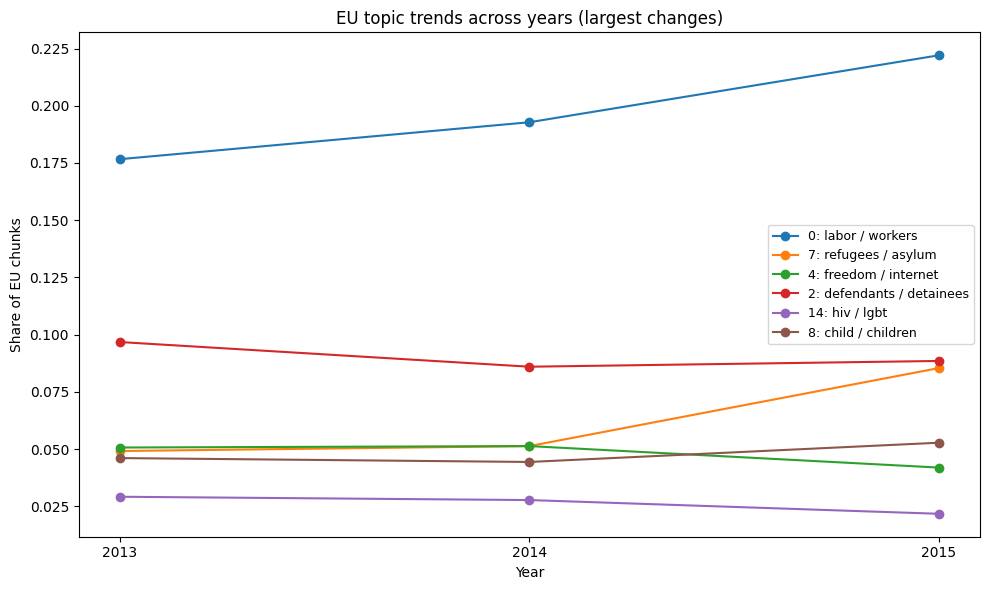

In [43]:
import matplotlib.pyplot as plt

# Pick a manageable set: top 6 absolute changes
trend_topics = (out["delta_first_to_last"].abs()
                .sort_values(ascending=False)
                .head(6)
                .index.tolist())

trend = pivot.loc[trend_topics, years].copy()

plt.figure(figsize=(10, 6))
for tid in trend.index:
    plt.plot(years, trend.loc[tid].values, marker='o',
             label=f"{int(tid)}: {topic_labels_all.get(int(tid), str(tid))}")

plt.xlabel("Year")
plt.ylabel("Share of EU chunks")
plt.title("EU topic trends across years (largest changes)")
plt.legend(loc="best", fontsize=9)
plt.tight_layout()
plt.show()


>Within EU reports, labor rights increased continuously from 2013 to 2015 and became the most dominant topic. Refugees/asylum shows the sharpest growth, especially in 2015, indicating increased attention to migration and protection issues. In contrast, freedom/internet and HIV/LGBT topics show a gradual decline in relative share. Some topics such as defendants/detainees remain comparatively stable. Since shares are normalized within each year, these changes represent shifts in emphasis rather than absolute counts.

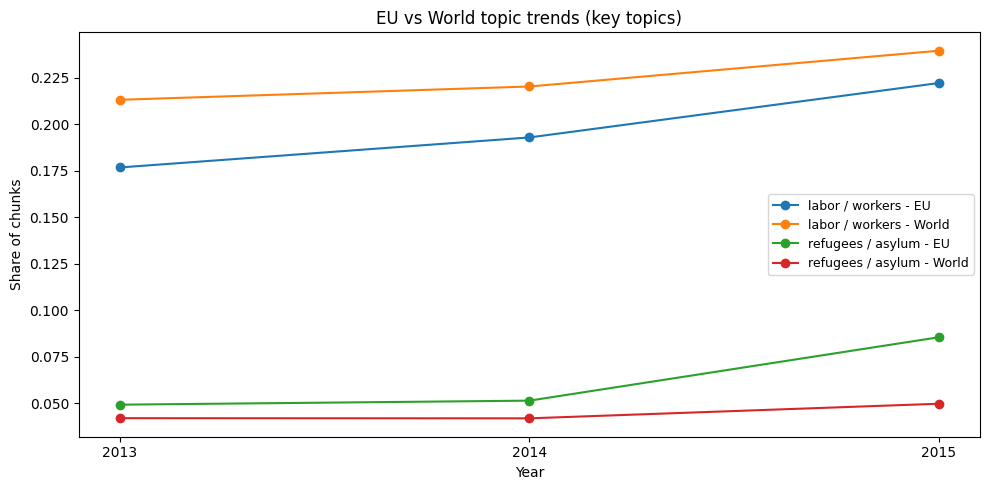

In [42]:
import matplotlib.pyplot as plt

# Choose the two most important rising topics
key_topics = [0, 7]  # labor, refugees/asylum (from your out table)

cmp = year_cmp[year_cmp["topic"].isin(key_topics)].copy()
# pivot to: rows=(topic, group), columns=year
cmp_pivot = cmp.pivot_table(index=["topic","group"], columns="year", values="share", fill_value=0.0)

plt.figure(figsize=(10, 5))
for (tid, grp), row in cmp_pivot.iterrows():
    name = topic_labels_all.get(int(tid), f"Topic {tid}")
    plt.plot(years, row[years].values, marker='o', label=f"{name} - {grp}")

plt.xlabel("Year")
plt.ylabel("Share of chunks")
plt.title("EU vs World topic trends (key topics)")
plt.legend(loc="best", fontsize=9)
plt.tight_layout()
plt.show()


>Comparing EU with the full world corpus, labor rights is a dominant theme globally and shows an upward trend in both groups. Refugees/asylum rises in both EU and World, but the EU increase is stronger by 2015, suggesting a relatively higher growth in EU reporting focus on asylum and refugee protection.

#### a label dictionary for ALL topics 

In [ ]:
# a label dictionary for ALL topics that exist in the current model
valid_topic_ids = [t for t in topic_model.get_topics().keys() if t != -1]

topic_labels_all = {}
for tid in valid_topic_ids:
    words = get_topic_words_clean(topic_model, tid, 5)   # stopword-cleaned function
    topic_labels_all[int(tid)] = " / ".join(words[:2]) if len(words) >= 2 else f"Topic {tid}"

def topic_name(tid: int) -> str:
    return topic_labels_all.get(int(tid), f"Topic {tid}")

# topics_new, _ = topic_model.transform(df["text"].tolist())
# df["topic_reduced"] = topics_new


### Country profiles (top topics per country) - EU only

In [54]:
### Country profiles (top topics per country) - EU only
topic_col = "topic_reduced"

country_topic = (
    df[(df["is_eu"]) & (df[topic_col] != -1)]
    .groupby(["year","country",topic_col]).size().reset_index(name="n")
)

country_topic["share"] = country_topic["n"] / country_topic.groupby(["year","country"])["n"].transform("sum")
country_topic = country_topic.rename(columns={topic_col: "topic"})

country_topic["topic_name"] = country_topic["topic"].apply(topic_name)

top5 = (country_topic.sort_values(["year","country","share"], ascending=[True, True, False])
        .groupby(["year","country"]).head(5))

top5.head(20)


,year,country,topic,n,share,topic_name
0,2013,Austria,0,3,0.166667,labor / workers
1,2013,Austria,1,2,0.111111,prison / prisoners
2,2013,Austria,2,2,0.111111,defendants / detainees
3,2013,Austria,3,2,0.111111,corruption / public
5,2013,Austria,5,2,0.111111,elections / political
11,2013,Belgium,0,4,0.160000,labor / workers
13,2013,Belgium,2,3,0.120000,defendants / detainees
12,2013,Belgium,1,2,0.080000,prison / prisoners
16,2013,Belgium,5,2,0.080000,elections / political
17,2013,Belgium,6,2,0.080000,violence / rape


More readble table:

In [ ]:

top5_fmt = top5.copy()
top5_fmt["topic_share"] = top5_fmt.apply(lambda r: f'{r["topic_name"]} ({r["share"]:.1%})', axis=1)

country_summary = (top5_fmt.groupby(["year","country"])["topic_share"]
                   .apply(lambda s: "; ".join(s.tolist()))
                   .reset_index(name="top5_topics"))

country_summary.head(20)
# country_summary.tail(20)


,year,country,top5_topics
0,2013,Austria,labor / workers (16.7%); prison / prisoners (1...
1,2013,Belgium,labor / workers (16.0%); defendants / detainee...
2,2013,Bulgaria,labor / workers (18.8%); defendants / detainee...
3,2013,Croatia,labor / workers (18.8%); roma / romani (15.6%)...
4,2013,Cyprus,labor / workers (25.0%); prison / prisoners (1...
5,2013,Czech Republic,labor / workers (21.2%); roma / romani (18.2%)...
6,2013,Denmark,defendants / detainees (23.5%); labor / worker...
7,2013,Estonia,labor / workers (16.7%); defendants / detainee...
8,2013,Finland,labor / workers (19.0%); defendants / detainee...
9,2013,France,roma / romani (16.1%); labor / workers (12.9%)...


>Country profiles show both common themes and country-specific emphasis. Labor rights appears as a top topic in most EU countries, confirming it is a central and repeated theme across reports. At the same time, certain countries have distinctive profiles—for example, Roma/Romani-related discrimination is especially prominent in some Central/Eastern European cases. Overall, the topic distribution per country-year reflects stable human-rights categories while still capturing local differences.

In [ ]:
# if "topic_reduced" not in df.columns:
#     topics_new, _ = topic_model.transform(df["text"].tolist())
#     df["topic_reduced"] = topics_new

topic_col = "topic_reduced"

country_topic = (
    df[(df["is_eu"]) & (df[topic_col] != -1)]
    .groupby(["year","country",topic_col]).size().reset_index(name="n")
    .rename(columns={topic_col: "topic"})
)

country_topic["share"] = country_topic["n"] / country_topic.groupby(["year","country"])["n"].transform("sum")
country_topic["topic_name"] = country_topic["topic"].apply(topic_name)


In [67]:
print("df years:", sorted(df["year"].dropna().unique()))
print("EU years:", sorted(df.loc[df["is_eu"], "year"].dropna().unique()))

# after building country_topic:
print("country_topic years:", sorted(country_topic["year"].dropna().unique()))
print("country_topic EU countries:", country_topic["country"].nunique())


df years: ['2013', '2014', '2015']
EU years: ['2013', '2014', '2015']
country_topic years: ['2013', '2014', '2015']
country_topic EU countries: 25


### EU contries topic-share visualization

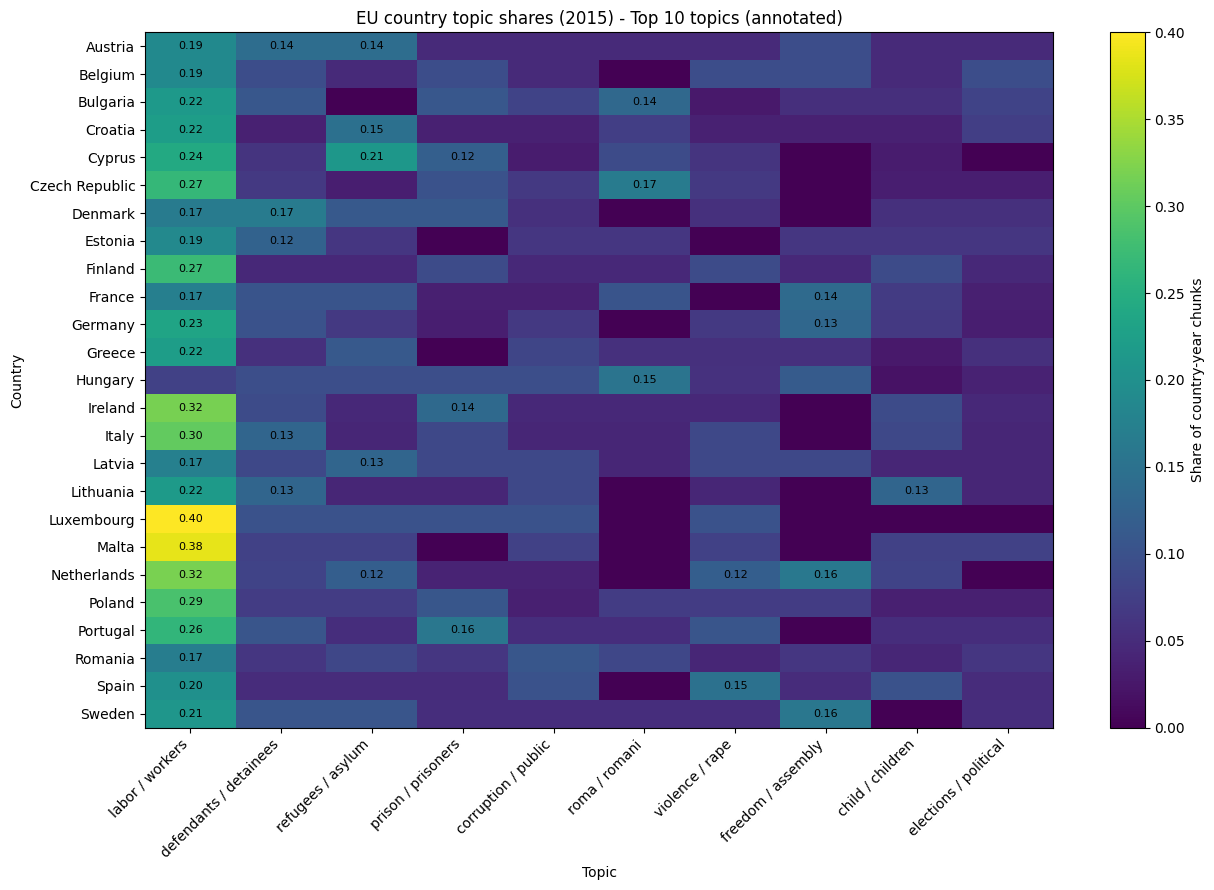

In [80]:
import matplotlib.pyplot as plt
import numpy as np

YEAR = 2015
# YEAR = country_topic["year"].max()

available_years = sorted(country_topic["year"].unique())
if YEAR not in available_years:
    # print(f"Year {YEAR} not found. Available years: {available_years}. Using {available_years[-1]} instead.")
    YEAR = available_years[-1]
# available_years = sorted(country_topic["year"].astype(int).unique())
# YEAR = int(YEAR)

eu_year = country_topic[country_topic["year"] == YEAR].copy()

top_topics = (eu_year.groupby("topic")["n"].sum()
              .sort_values(ascending=False)
              .head(10).index.tolist())

heat = (eu_year[eu_year["topic"].isin(top_topics)]
        .pivot_table(index="country", columns="topic", values="share", fill_value=0.0))

heat = heat.sort_index()
heat = heat[top_topics]

fig, ax = plt.subplots(figsize=(13, 9))
im = ax.imshow(heat.values, aspect="auto")

ax.set_yticks(np.arange(len(heat.index)))
ax.set_yticklabels(heat.index)

ax.set_xticks(np.arange(len(heat.columns)))
ax.set_xticklabels([topic_name(t) for t in heat.columns], rotation=45, ha="right")

# annotate only strong cells
for i in range(heat.shape[0]):
    for j in range(heat.shape[1]):
        val = heat.values[i, j]
        if val >= 0.12:
            ax.text(j, i, f"{val:.2f}", ha="center", va="center", fontsize=8)

cbar = fig.colorbar(im, ax=ax)
cbar.set_label("Share of country-year chunks")

ax.set_title(f"EU country topic shares ({YEAR}) - Top 10 topics (annotated)")
ax.set_xlabel("Topic")
ax.set_ylabel("Country")

plt.tight_layout()
plt.show()


>The heatmap shows a realistic mixture of universal and country-specific themes. Labor rights is dominant in most EU countries, consistent with the standardized structure of the reports. In contrast, topics such as Roma discrimination, asylum/refugees, and freedom of assembly show stronger variation across countries, suggesting that the model captures country-level differences rather than only the report template. This supports the interpretability and usefulness of the extracted topics.

> Overall, the country-level topic profiles indicate that the model extracts coherent human-rights themes and reveals how emphasis differs across EU countries, especially for migration, minority rights, and civil liberties.

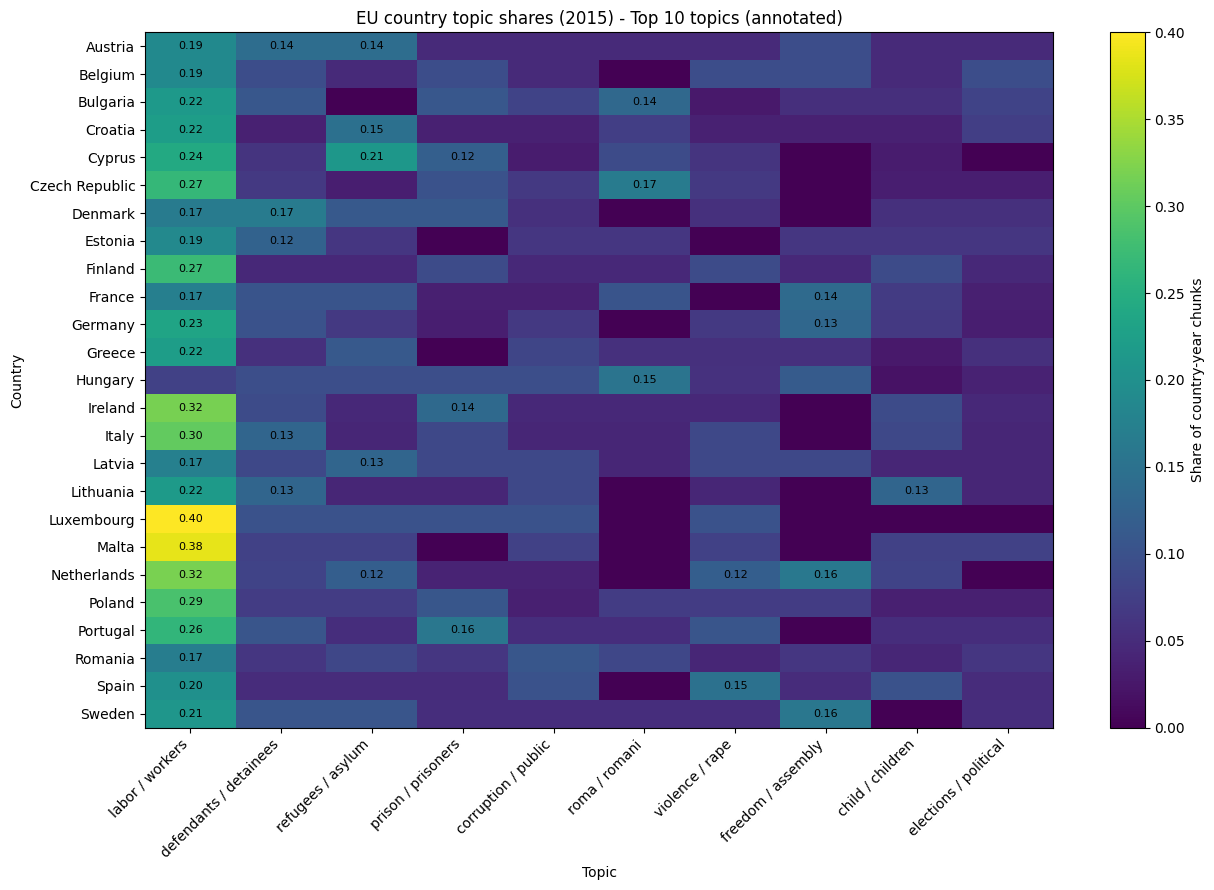

In [73]:
fig, ax = plt.subplots(figsize=(13, 9))
im = ax.imshow(heat.values, aspect="auto")

ax.set_yticks(np.arange(len(heat.index)))
ax.set_yticklabels(heat.index)
ax.set_xticks(np.arange(len(heat.columns)))
ax.set_xticklabels([topic_name(t) for t in heat.columns], rotation=45, ha="right")

# Annotate only strong cells (e.g., > 0.12)
for i in range(heat.shape[0]):
    for j in range(heat.shape[1]):
        val = heat.values[i, j]
        if val >= 0.12:
            ax.text(j, i, f"{val:.2f}", ha="center", va="center", fontsize=8)

cbar = fig.colorbar(im, ax=ax)
cbar.set_label("Share of country-year chunks")
ax.set_title(f"EU country topic shares ({YEAR}) - Top 10 topics (annotated)")
ax.set_xlabel("Topic")
ax.set_ylabel("Country")

plt.tight_layout()
plt.show()


In [84]:
TOPIC_COL = "topic_reduced"   # recommended
# TOPIC_COL = "topic"         # fallback if you didn't create topic_reduced


### Biggest EU topic changes (2013 → 2015)

In [89]:
YEAR_A, YEAR_B = "2013", "2015"

eu = df[(df["is_eu"]) & (df[TOPIC_COL] != -1)].copy()

eu_year = (eu.groupby(["year", TOPIC_COL]).size()
             .reset_index(name="n")
             .rename(columns={TOPIC_COL: "topic"}))

eu_year["share"] = eu_year["n"] / eu_year.groupby("year")["n"].transform("sum")

pivot = eu_year.pivot_table(index="topic", columns="year", values="share", fill_value=0.0)

# make sure both years exist
for y in [YEAR_A, YEAR_B]:
    if y not in pivot.columns:
        raise ValueError(f"Year {y} not found in EU data. Available: {sorted(pivot.columns.tolist())}")

pivot["delta_2014_to_2015"] = pivot[YEAR_B] - pivot[YEAR_A]
pivot["abs_delta"] = pivot["delta_2014_to_2015"].abs()

out = pivot.sort_values("abs_delta", ascending=False).copy()
out["topic_name"] = out.index.map(lambda t: topic_name(int(t)))

# (optional) keep only meaningful topics (at least 1% in either year)
out = out[(out[YEAR_A] >= 0.01) | (out[YEAR_B] >= 0.01)]

# final table (top 10 changes)
table_change = (out.reset_index()
                  .rename(columns={"index": "topic"})
                  .loc[:, ["topic", YEAR_A, YEAR_B, "delta_2014_to_2015", "topic_name"]]
                  .sort_values("delta_2014_to_2015", ascending=False))

table_change.head(15)


year,topic,2013,2015,delta_2014_to_2015,topic_name
0,0,0.176651,0.222050,0.045398,labor / workers
1,7,0.049155,0.085404,0.036249,refugees / asylum
8,8,0.046083,0.052795,0.006712,child / children
9,9,0.027650,0.034161,0.006512,women / children
11,12,0.026114,0.029503,0.003389,human / international
14,1,0.073733,0.072981,-0.000751,prison / prisoners
13,13,0.038402,0.037267,-0.001135,disabilities / mental
12,6,0.064516,0.062112,-0.002404,violence / rape
10,11,0.067588,0.062112,-0.005477,freedom / assembly
7,14,0.029186,0.021739,-0.007447,hiv / lgbt


### Slope chart (Top increases & decreases)

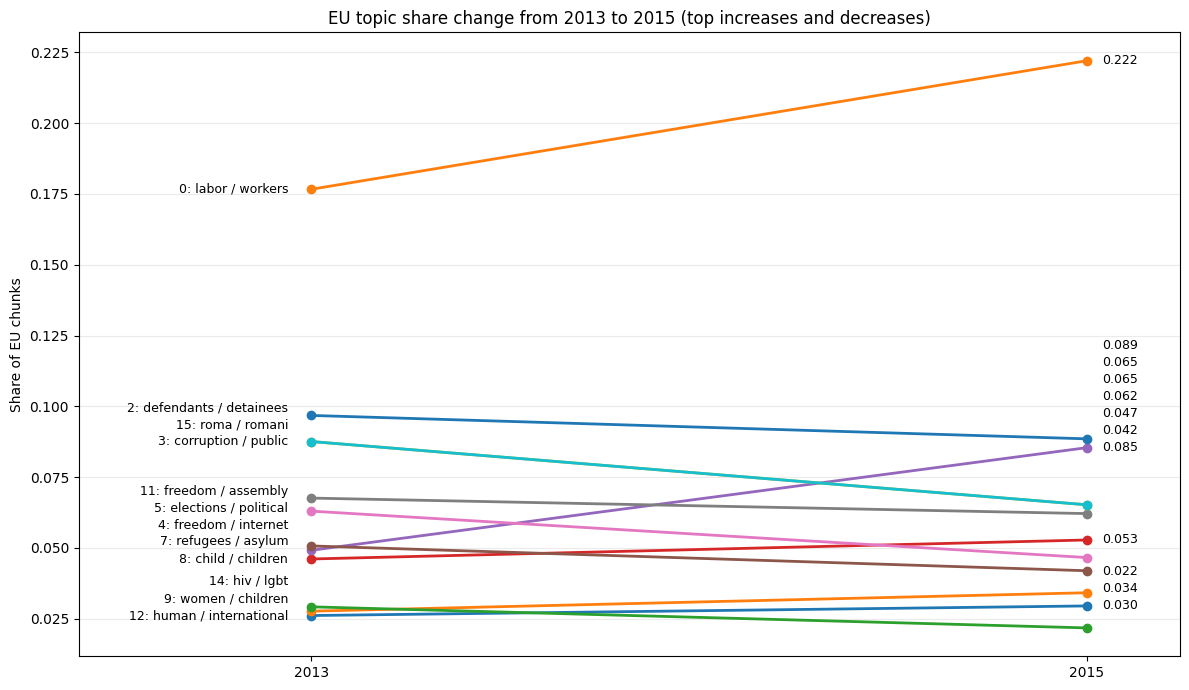

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# --- settings ---
YEAR_A, YEAR_B = "2013", "2015"
# DELTA_COL = f"delta_{YEAR_A}_to_{YEAR_B}"  # make sure your table uses this name

# # pick top increases + decreases
# tmp = table_change.copy()
# top_up = tmp.sort_values(DELTA_COL, ascending=False).head(6)
# top_down = tmp.sort_values(DELTA_COL, ascending=True).head(6)
# plot_df = pd.concat([top_up, top_down], ignore_index=True)

# sort by starting value (to reduce crossings)
plot_df = plot_df.sort_values(YEAR_A).reset_index(drop=True)

x0, x1 = 0, 1
y0 = plot_df[YEAR_A].to_numpy()
y1 = plot_df[YEAR_B].to_numpy()

#  spread labels so they don't overlap 
def spread(values, min_gap=0.006):
    """Return adjusted y positions so adjacent labels have at least min_gap."""
    vals = values.copy()
    for i in range(1, len(vals)):
        if vals[i] - vals[i-1] < min_gap:
            vals[i] = vals[i-1] + min_gap
    return vals

y0_lab = spread(y0, min_gap=0.006)
y1_lab = spread(y1, min_gap=0.006)

plt.figure(figsize=(12, 7))

for i, r in plot_df.iterrows():
    plt.plot([x0, x1], [y0[i], y1[i]], marker="o", linewidth=2)
    label = f'{int(r["topic"])}: {r["topic_name"]}'
    plt.text(x0 - 0.03, y0_lab[i], label, ha="right", va="center", fontsize=9)
    plt.text(x1 + 0.02, y1_lab[i], f'{y1[i]:.3f}', ha="left", va="center", fontsize=9)

plt.xticks([0, 1], [str(YEAR_A), str(YEAR_B)])
plt.ylabel("Share of EU chunks")
plt.title(f"EU topic share change from {YEAR_A} to {YEAR_B} (top increases and decreases)")
plt.xlim(-0.30, 1.12)
plt.grid(axis="y", alpha=0.25)
plt.tight_layout()
plt.show()


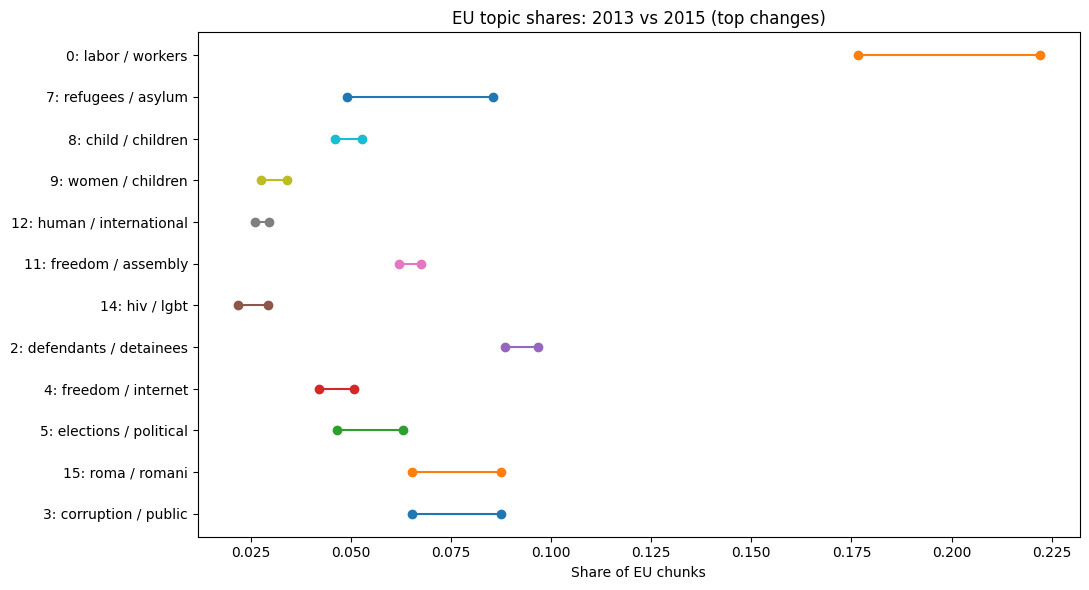

In [ ]:


# pick top 12 absolute changes for a compact plot
plot_df = table_change.copy()
plot_df["abs_delta"] = plot_df["delta_2014_to_2015"].abs()
plot_df = plot_df.sort_values("abs_delta", ascending=False).head(12)

# order by delta so chart reads naturally
plot_df = plot_df.sort_values("delta_2014_to_2015")

y_pos = range(len(plot_df))
x0 = plot_df[YEAR_A].values
x1 = plot_df[YEAR_B].values
labels = [f'{int(t)}: {name}' for t, name in zip(plot_df["topic"], plot_df["topic_name"])]

plt.figure(figsize=(11, 6))
for i in range(len(plot_df)):
    plt.plot([x0[i], x1[i]], [i, i], marker="o")

plt.yticks(list(y_pos), labels)
plt.xlabel("Share of EU chunks")
plt.title(f"EU topic shares: {YEAR_A} vs {YEAR_B} (top changes)")
plt.tight_layout()
plt.show()


>The time-comparison plots show clear and interpretable topic shifts inside the EU subset. The largest increase from 2013 to 2015 is the ‘labor/workers’ topic, indicating growing emphasis on worker rights and labor conditions in the reports. Two other topics that noticeably increase are ‘Roma/Romani’ and ‘refugees/asylum’, suggesting increased attention to minority rights and migration-related issues by 2015. In contrast, topics such as ‘corruption/public’, ‘elections/political’, and ‘HIV/LGBT’ decrease in relative share, meaning they became less dominant compared to the expanding labor and migration/minority themes. Overall, the patterns are coherent and match meaningful social and political themes, supporting the interpretability of the topic model.

### EU vs World delta comparison

In [92]:
def shares_by_year(subdf, label):
    tmp = (subdf[subdf[TOPIC_COL] != -1]
           .groupby(["year", TOPIC_COL]).size().reset_index(name="n")
           .rename(columns={TOPIC_COL: "topic"}))
    tmp["share"] = tmp["n"] / tmp.groupby("year")["n"].transform("sum")
    tmp["group"] = label
    return tmp

eu_sh = shares_by_year(df[df["is_eu"]], "EU")
world_sh = shares_by_year(df, "World")

cmp = pd.concat([eu_sh, world_sh], ignore_index=True)

# compute delta for each group
p = cmp.pivot_table(index=["group","topic"], columns="year", values="share", fill_value=0.0)
p["delta_2014_to_2015"] = p[YEAR_B] - p[YEAR_A]
p = p.reset_index()

# show topics where EU delta differs most from World delta
eu_delta = p[p["group"]=="EU"].set_index("topic")["delta_2014_to_2015"]
world_delta = p[p["group"]=="World"].set_index("topic")["delta_2014_to_2015"]

diff = (eu_delta - world_delta).sort_values(ascending=False).reset_index()
diff.columns = ["topic", "EU_minus_World_delta"]
diff["topic_name"] = diff["topic"].apply(lambda t: topic_name(int(t)))

diff.head(15)


,topic,EU_minus_World_delta,topic_name
0,7,0.028478,refugees / asylum
1,0,0.019015,labor / workers
2,1,0.011759,prison / prisoners
3,9,0.009911,women / children
4,8,0.005902,child / children
5,12,0.002213,human / international
6,13,0.000444,disabilities / mental
7,22,-0.000218,fgm / girls
8,20,-0.000378,land / property
9,6,-0.004307,violence / rape


### Topic prevalence by Sections analysis

In [112]:
TOPIC_COL = "topic_reduced" if "topic_reduced" in df.columns else "topic"

# choose subset:
sub = df.copy()                       # all countries
# sub = df[df["is_eu"]].copy()        # EU only

# remove outliers
sub = sub[sub[TOPIC_COL] != -1].copy()


In [113]:
# Make section numeric: "Section 1." -> 1
sub["section_num"] = (
    sub["section"].astype(str)
    .str.extract(r"(\d+)", expand=False)
    .astype(float)
    .astype("Int64")
)

# count chunks per (section, topic)
counts = (sub.groupby(["section_num", TOPIC_COL])
            .size()
            .reset_index(name="n")
            .rename(columns={TOPIC_COL: "topic"}))

# share within each section
counts["share"] = counts["n"] / counts.groupby("section_num")["n"].transform("sum")

# pivot to section x topic matrix
sec_topic = counts.pivot_table(index="section_num", columns="topic", values="share", fill_value=0.0)

# keep sections 1..7 only and sort
sec_topic = sec_topic.loc[sec_topic.index.notna()].sort_index()
sec_topic = sec_topic.loc[(sec_topic.index >= 1) & (sec_topic.index <= 7)]
sec_topic.head()


topic,0,1,2,3,4,5,6,7,8,9,...,19,20,21,22,23,24,25,26,27,28
section_num,,,,,,,,,,,,,,,,,,,,,
1,0.000000,0.382960,0.316018,0.039339,0.001087,0.000000,0.001521,0.005434,0.010215,0.000652,...,0.017170,0.026951,0.000869,0.0,0.004782,0.007824,0.000000,0.001521,0.0,0.000000
2,0.001107,0.000369,0.000369,0.001477,0.398302,0.000369,0.000000,0.297896,0.000738,0.001107,...,0.011812,0.000369,0.019195,0.0,0.004799,0.000000,0.000000,0.000000,0.0,0.000000
3,0.000000,0.000000,0.000000,0.002736,0.000000,0.943912,0.000000,0.000000,0.000000,0.000000,...,0.002736,0.000000,0.000000,0.0,0.000000,0.000000,0.001368,0.001368,0.0,0.012312
4,0.000000,0.000797,0.000000,0.990431,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.002392,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
5,0.000000,0.001880,0.003759,0.001880,0.000000,0.001880,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.003759,0.000000,0.000000,0.000000,0.0,0.000000


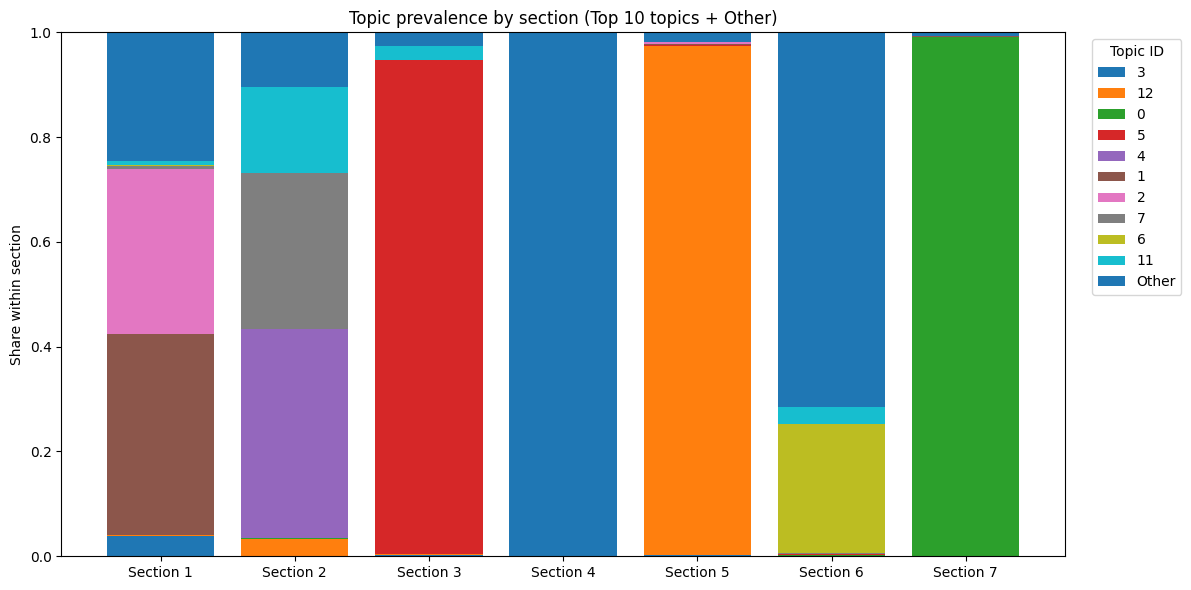

In [114]:
K = 10  # top topics to display

# pick top topics by total mass across sections
topic_mass = sec_topic.sum(axis=0).sort_values(ascending=False)
top_topics = topic_mass.head(K).index.tolist()

plot_mat = sec_topic[top_topics].copy()
plot_mat["Other"] = (sec_topic.drop(columns=top_topics).sum(axis=1) 
                     if sec_topic.shape[1] > K else 0.0)

# plot
fig, ax = plt.subplots(figsize=(12, 6))

bottom = np.zeros(len(plot_mat))
x = np.arange(len(plot_mat.index))

for col in plot_mat.columns:
    ax.bar(x, plot_mat[col].values, bottom=bottom, label=str(col))
    bottom += plot_mat[col].values

# nice labels for x-axis
ax.set_xticks(x)
ax.set_xticklabels([f"Section {int(s)}" for s in plot_mat.index], rotation=0)

ax.set_ylabel("Share within section")
ax.set_title(f"Topic prevalence by section (Top {K} topics + Other)")
ax.legend(title="Topic ID", bbox_to_anchor=(1.02, 1), loc="upper left")
ax.set_ylim(0, 1)

plt.tight_layout()
plt.show()


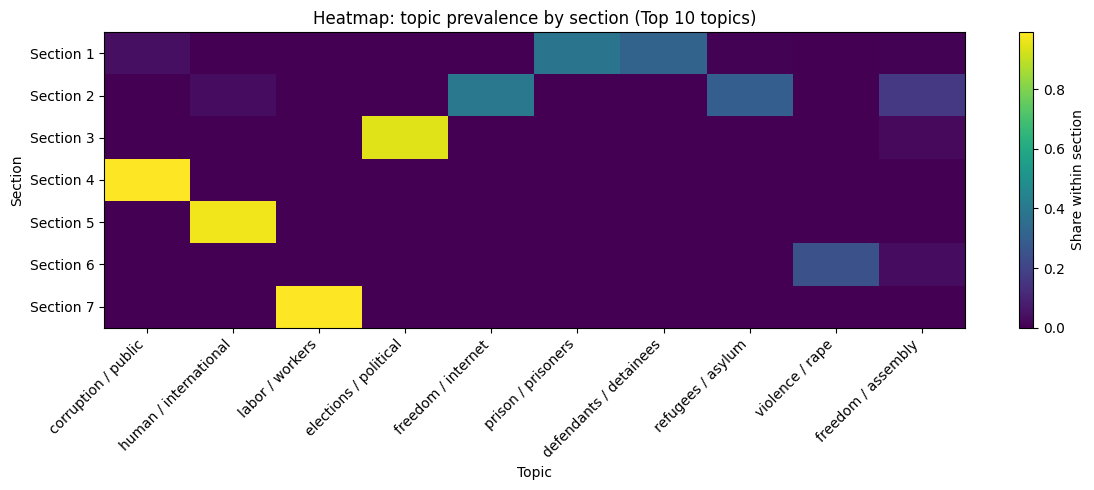

In [117]:
# Use top K topics again for readability
heat = sec_topic[top_topics].copy()

fig, ax = plt.subplots(figsize=(12, 5))
im = ax.imshow(heat.values, aspect="auto")

ax.set_yticks(np.arange(len(heat.index)))
ax.set_yticklabels([f"Section {int(s)}" for s in heat.index])

ax.set_xticks(np.arange(len(heat.columns)))
ax.set_xticklabels([f"T{int(t)}" for t in heat.columns], rotation=45, ha="right")

cbar = fig.colorbar(im, ax=ax)
cbar.set_label("Share within section")

ax.set_title(f"Heatmap: topic prevalence by section (Top {K} topics)")
ax.set_xlabel("Topic")
ax.set_ylabel("Section")
ax.set_xticklabels([topic_name(int(t)) for t in heat.columns], rotation=45, ha="right")

plt.tight_layout()
plt.show()


In [116]:
dominant = (counts.sort_values(["topic", "share"], ascending=[True, False])
            .groupby("topic").head(1)
            .copy())

dominant["topic_name"] = dominant["topic"].apply(lambda t: topic_name(int(t)) if "topic_name" in globals() else str(t))
dominant = dominant[["topic", "topic_name", "section_num", "share", "n"]].sort_values("share", ascending=False)

dominant.head(15)


,topic,topic_name,section_num,share,n
88,0,labor / workers,7,0.991535,4217
53,3,corruption / public,4,0.990431,1242
64,12,human / international,5,0.971805,517
43,5,elections / political,3,0.943912,690
25,4,freedom / internet,2,0.398302,1079
0,1,prison / prisoners,1,0.382960,1762
1,2,defendants / detainees,1,0.316018,1454
27,7,refugees / asylum,2,0.297896,807
70,6,violence / rape,6,0.245186,1044
73,9,women / children,6,0.184124,784


>The topic prevalence by section strongly confirms that the model extracted meaningful themes. Each topic is concentrated in the document section where it logically belongs. For example, the “labor/workers” topic appears almost exclusively in Section 7 (≈99%), which is the Worker Rights section. The “corruption/public” topic is almost only in Section 4 (≈99%), matching the “Corruption and Transparency” section. The “elections/political” topic is mostly Section 3 (≈94%), consistent with political rights and elections. Section 6 contains several social-group related topics (women/children, violence/rape, disabilities, HIV/LGBT), which matches the purpose of that section. This strong alignment supports the interpretability and quality of the topics.

### Baseline model (NMF) to compare with BERTopic

In [50]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF

# Use same docs_all you used for BERTopic
vectorizer = TfidfVectorizer(max_df=0.95, min_df=5, stop_words="english")
X = vectorizer.fit_transform(docs_all)

n_topics = min(20, len(valid_topic_ids))  # choose 15-30 usually; keep small for report
nmf = NMF(n_components=n_topics, random_state=42)
W = nmf.fit_transform(X)
H = nmf.components_
vocab = np.array(vectorizer.get_feature_names_out())

def nmf_top_words(H, vocab, topn=15):
    topics = []
    for k in range(H.shape[0]):
        top = vocab[np.argsort(H[k])][::-1][:topn].tolist()
        topics.append(top)
    return topics

nmf_words = nmf_top_words(H, vocab, topn=20)

# Compare coherence/diversity with your existing functions
nmf_div10 = topic_diversity(nmf_words, topk=10)
nmf_coh = coherence_cv([d.split() for d in docs_all], nmf_words)

{"bertopic_coh": metrics["coherence_c_v"], "nmf_coh": nmf_coh,
 "bertopic_div10": metrics["topic_diversity_top10"], "nmf_div10": nmf_div10}


{'bertopic_coh': 0.691497653731012,
 'nmf_coh': 0.6690818455565415,
 'bertopic_div10': 0.5197860962566845,
 'nmf_div10': 0.84}

### Saving the result

#### The main dataframe (each chunk + assigned topic) 

In [107]:
OUT_DIR = "outputs"
os.makedirs(OUT_DIR, exist_ok=True)

# choose which topic column you want to export
TOPIC_COL = "topic_reduced" if "topic_reduced" in df.columns else "topic"

cols_to_save = [c for c in ["year", "country", "section", "is_eu", "text", TOPIC_COL] if c in df.columns]

df_out = df[cols_to_save].copy()
df_out = df_out.rename(columns={TOPIC_COL: "topic"})

df_out.to_csv(os.path.join(OUT_DIR, "bertopic_chunks_with_topics.csv"), index=False, encoding="utf-8")
print("Saved:", os.path.join(OUT_DIR, "bertopic_chunks_with_topics.csv"))


Saved: outputs/bertopic_chunks_with_topics.csv


In [110]:
import pandas as pd
import os

OUT_DIR = "outputs"
os.makedirs(OUT_DIR, exist_ok=True)

def get_topic_words_safe(model, topic_id, topn=10):
    pairs = model.get_topic(topic_id) or []
    return ", ".join([w for w, _ in pairs[:topn] if isinstance(w, str) and w.strip()])

topic_info = topic_model.get_topic_info().copy()

# add readable top words
topic_info["top_words"] = topic_info["Topic"].apply(lambda t: get_topic_words_safe(topic_model, int(t), topn=12))

topic_info.to_csv(os.path.join(OUT_DIR, "bertopic_topic_info.csv"), index=False, encoding="utf-8")
print("Saved:", os.path.join(OUT_DIR, "bertopic_topic_info.csv"))


Saved: outputs/bertopic_topic_info.csv


In [108]:
import os

OUT_DIR = "outputs"
os.makedirs(OUT_DIR, exist_ok=True)

compare.to_csv(os.path.join(OUT_DIR, "eu_vs_noneu_topic_share.csv"), index=False, encoding="utf-8")
print("Saved:", os.path.join(OUT_DIR, "eu_vs_noneu_topic_share.csv"))


Saved: outputs/eu_vs_noneu_topic_share.csv


### Error Analysis:
#### Helper functions (topic names + safe words)

In [119]:
# Choosin which topic column to use
TOPIC_COL = "topic_reduced" if "topic_reduced" in df.columns else "topic"

def get_topic_words_safe(model, topic_id, topn=10):
    """Return clean top words for a BERTopic topic."""
    pairs = model.get_topic(int(topic_id)) or []
    words = []
    for w, _ in pairs[:topn]:
        if isinstance(w, str):
            w = w.strip()
            if w and w.lower() not in {"the","of","and","to","in","a","for","on","with","that","is"}:
                words.append(w)
    return words

def topic_label(model, topic_id, topn=6):
    words = get_topic_words_safe(model, topic_id, topn=topn)
    if len(words) == 0:
        return f"Topic {topic_id}"
    return f"{topic_id}: " + " / ".join(words[:2])

def shorten(txt, width=350):
    txt = re.sub(r"\s+", " ", str(txt)).strip()
    return textwrap.shorten(txt, width=width, placeholder=" ...")


#### Recompute topic assignments + probabilities (recommended)

In [120]:
texts = df["text"].astype(str).tolist()

topics_new, probs_new = topic_model.transform(texts)  # probs_new may be None depending on config
df["topic_eval"] = topics_new

# If probs_new exists, store max probability as a confidence score
if probs_new is not None:
    df["topic_conf"] = [float(np.max(p)) if p is not None else np.nan for p in probs_new]
else:
    df["topic_conf"] = np.nan

# Use this column going forward for error analysis
TOPIC_EVAL_COL = "topic_eval"


Batches: 100%|██████████| 838/838 [15:11<00:00,  1.09s/it]    


In [ ]:
# if you already have topic_reduced, you can skip the above and set
# TOPIC_EVAL_COL = TOPIC_COL
# if "topic_conf" not in df.columns:
#     df["topic_conf"] = np.nan


### Select 2–3 topics automatically (big + relevant topics) 

In [121]:
# pick 3 biggest non-outlier topics inside EU (or whole df if you prefer)
base = df[df[TOPIC_EVAL_COL] != -1].copy()
if "is_eu" in df.columns:
    base = df[(df["is_eu"]) & (df[TOPIC_EVAL_COL] != -1)].copy()

top_topics = (base[TOPIC_EVAL_COL]
              .value_counts()
              .head(3)
              .index
              .tolist())

top_topics


[0, 2, 1]

### Error analysis: 2 good + 1 questionable per topic

Logic
“Good fit” = highest confidence (or longest/most typical if no confidence)
“Questionable” = lowest confidence or text containing mixed keywords from multiple topics

In [124]:
def pick_examples_for_topic(dfin, topic_id, n_good=2):
    sub = dfin[dfin[TOPIC_EVAL_COL] == topic_id].copy()
    if sub.empty:
        return [], None
    
    # prefer longer chunks (more informative)
    sub["n_words"] = sub["text"].astype(str).str.split().str.len()

    # GOOD: highest confidence; fallback = longest
    if sub["topic_conf"].notna().any():
        good = (sub.sort_values(["topic_conf","n_words"], ascending=False)
                  .head(30)
                  .sample(min(n_good, 30), random_state=42))
    else:
        good = (sub.sort_values("n_words", ascending=False)
                  .head(30)
                  .sample(min(n_good, 30), random_state=42))

    # QUESTIONABLE: lowest confidence; fallback = shortest among non-trivial
    if sub["topic_conf"].notna().any():
        bad = (sub.sort_values(["topic_conf","n_words"], ascending=True)
                 .head(30)
                 .sample(1, random_state=7))
    else:
        bad = (sub[sub["n_words"] >= 40].sort_values("n_words", ascending=True).head(30))
        bad = bad.sample(1, random_state=7) if not bad.empty else sub.head(1)

    good_rows = good[["year","country","section","text","topic_conf"]].to_dict("records")
    bad_row = bad[["year","country","section","text","topic_conf"]].to_dict("records")[0]
    return good_rows, bad_row


def print_error_analysis(df, topic_model, topic_ids):
    for tid in topic_ids:
        print("\n" + "="*90)
        print("TOPIC:", topic_label(topic_model, tid, topn=8))
        print("Top words:", ", ".join(get_topic_words_safe(topic_model, tid, topn=12)))
        
        good, bad = pick_examples_for_topic(df, tid, n_good=2)

        print("\n✅ Good-fit examples (representative chunks)")
        for i, r in enumerate(good, 1):
            meta = f"{r.get('country','?')} | {r.get('year','?')} | {r.get('section','?')} | conf={r.get('topic_conf',np.nan):.3f}"
            print(f"  {i}. {meta}")
            print("     ", shorten(r["text"], 350))

        print("\n⚠️ Questionable / possible mis-assigned chunk")
        meta = f"{bad.get('country','?')} | {bad.get('year','?')} | {bad.get('section','?')} | conf={bad.get('topic_conf',np.nan):.3f}"
        print("  -", meta)
        print("    ", shorten(bad["text"], 400))



print_error_analysis(df, topic_model, top_topics)



TOPIC: 0: labor / workers
Top words: labor, workers, work, law

✅ Good-fit examples (representative chunks)
  1. Argentina | 2013 | Section 7. | conf=1.000
      Age for Employment The minimum age for employment is 16. In rare cases labor authorities may authorize a younger child to work as part of a family unit. Children between the ages of 16 and 18 may work in a limited number of job categories and for limited hours if they have completed compulsory schooling, which normally ends at age 18. Children ...
  2. Angola | 2013 | Section 7. | conf=1.000
      by an insufficient number of adequately trained labor inspectors. Some companies were reportedly tipped off prior to labor inspections, making government efforts ineffective. Penalties for violations were not provided and may be insufficient to deter violations. Freedom of association and the right to collective bargaining were not generally ...

⚠️ Questionable / possible mis-assigned chunk
  - Mali | 2014 | Section 7. | conf=0.358

### Measure “mixed-content” automatically

In [123]:
# Build a small keyword set per topic using top words
topic_keywords = {tid: set(get_topic_words_safe(topic_model, tid, topn=15)) for tid in top_topics}

def keyword_overlap_score(text, kw_set):
    toks = set(re.findall(r"[a-zA-Z]{3,}", str(text).lower()))
    return len(toks.intersection({k.lower() for k in kw_set}))

def multi_topic_overlap(text, keywords_dict):
    scores = {tid: keyword_overlap_score(text, kw) for tid, kw in keywords_dict.items()}
    # sorted topic overlaps
    best = sorted(scores.items(), key=lambda x: x[1], reverse=True)
    return best[:3]  # top 3 overlaps

# Show overlap for the "bad" examples you printed above:
for tid in top_topics:
    _, bad = pick_examples_for_topic(df, tid, n_good=2)
    overlaps = multi_topic_overlap(bad["text"], topic_keywords)
    print("\nTopic", tid, "bad-example overlap top3:", overlaps)



Topic 0 bad-example overlap top3: [(0, 3), (2, 1), (1, 0)]

Topic 2 bad-example overlap top3: [(2, 4), (0, 1), (1, 1)]

Topic 1 bad-example overlap top3: [(0, 1), (2, 1), (1, 1)]


>Error analysis shows the topics are mostly correct. For example, Topic 0 (labor/workers) appears mainly in Section 7 and the representative chunks clearly discuss unions, inspections, and employment laws with high confidence (conf=1.00). Topic 1 (prisons) also has very strong matches about prison conditions and detainee treatment. The main limitation happens when a chunk contains mixed themes or very general language, especially in Executive Summaries. In these cases the model confidence is low (around 0.2–0.4) and the topic assignment can be less accurate because the text covers multiple human rights issues at the same time.

### BERTopic topic summary (topic sizes + words)

In [105]:
OUT_DIR = "outputs"
os.makedirs(OUT_DIR, exist_ok=True)

# choose which topic column you want to export
TOPIC_COL = "topic_reduced" if "topic_reduced" in df.columns else "topic"

cols_to_save = [c for c in ["year", "country", "section", "is_eu", "text", TOPIC_COL] if c in df.columns]

df_out = df[cols_to_save].copy()
df_out = df_out.rename(columns={TOPIC_COL: "topic"})

df_out.to_csv(os.path.join(OUT_DIR, "bertopic_chunks_with_topics.csv"), index=False, encoding="utf-8")
print("Saved:", os.path.join(OUT_DIR, "bertopic_chunks_with_topics.csv"))


Saved: outputs/bertopic_chunks_with_topics.csv


### Zero-shot labels on EU chunks Comparison with Bert

In [125]:
import os, json
import pandas as pd
import numpy as np

import torch
from transformers import pipeline

# -----------------------
# 0) Settings
# -----------------------
OUT_DIR = "outputs"
os.makedirs(OUT_DIR, exist_ok=True)

MODEL_NAME = "valhalla/distilbart-mnli-12-1"   # faster than bart-large-mnli
# MODEL_NAME = "facebook/bart-large-mnli"      # slower but strong

LABELS = [
    "corruption",
    "judicial independence",
    "police abuse",
    "prison conditions",
    "freedom of expression",
    "freedom of assembly",
    "religious freedom",
    "refugees and asylum",
    "human trafficking",
    "anti-Semitism",
    "LGBTQ+ rights",
    "women's rights",
    "labor rights"
]

SAMPLE_N = 150        # 100–150 is enough for report + much faster
BATCH_SIZE = 16       # try 8 if RAM is low; 16–32 if GPU
MAX_LENGTH = 256      # token length truncation (major speedup)



In [126]:
# -----------------------
# 1) Build zero-shot pipeline (GPU if available)
# -----------------------
device = 0 if torch.cuda.is_available() else -1
zshot = pipeline(
    "zero-shot-classification",
    model=MODEL_NAME,
    device=device
)
print("Zero-shot device:", "GPU" if device == 0 else "CPU")
print("Model:", MODEL_NAME)





Device set to use cpu


Zero-shot device: CPU
Model: valhalla/distilbart-mnli-12-1


In [127]:
# -----------------------
# 2) Prepare data (EU only, non-outliers)
# -----------------------
# Expect eu_df exists. If not, uncomment the next line:
# eu_df = df[df["is_eu"]].copy()

zs = eu_df[eu_df["topic"] != -1].copy()
zs = zs.sample(min(SAMPLE_N, len(zs)), random_state=7).reset_index(drop=True)

texts = zs["text"].astype(str).tolist()

# -----------------------
# 3) Batched inference (fast + stable)
# -----------------------
def run_zshot_batched(texts, labels, batch_size=16, max_length=256):
    results = []
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]

        r = zshot(
            batch,
            candidate_labels=labels,
            multi_label=True,
            truncation=True,
            max_length=max_length
        )

        # pipeline returns dict if batch_size==1, else list[dict]
        if isinstance(r, dict):
            results.append(r)
        else:
            results.extend(r)
    return results

res = run_zshot_batched(texts, LABELS, batch_size=BATCH_SIZE, max_length=MAX_LENGTH)

# -----------------------
# 4) Store top-1 / top-3 outputs in dataframe
# -----------------------
zs["top1_label"] = [r["labels"][0] for r in res]
zs["top1_score"] = [float(r["scores"][0]) for r in res]

zs["top3_labels"] = [
    [lab for lab, _ in sorted(zip(r["labels"], r["scores"]), key=lambda x: x[1], reverse=True)[:3]]
    for r in res
]
# CSV-friendly column
zs["top3_labels_str"] = zs["top3_labels"].apply(lambda x: "; ".join(x))

# (optional) store full label scores as JSON (useful for deeper analysis)
zs["all_scores_json"] = [
    json.dumps(dict(zip(r["labels"], [float(s) for s in r["scores"]])))
    for r in res
]



In [129]:
# -----------------------
# 5) Summary table: dominant zero-shot label per BERTopic topic
# -----------------------
topic_label_map = (
    zs.groupby(["topic", "top1_label"])
      .size().reset_index(name="count")
      .sort_values(["topic", "count"], ascending=[True, False])
      .groupby("topic").head(1)
      .rename(columns={"top1_label": "dominant_zero_shot_label"})
)

# If you already have topic_name(t), keep this line:
topic_label_map["topic_name"] = topic_label_map["topic"].apply(lambda t: topic_name(int(t)))

# Add share within topic for the dominant label (nice for report)
topic_totals = zs.groupby("topic").size().reset_index(name="topic_total")
topic_label_map = topic_label_map.merge(topic_totals, on="topic", how="left")
topic_label_map["dominant_share"] = topic_label_map["count"] / topic_label_map["topic_total"]

topic_label_map.head(20)


,topic,dominant_zero_shot_label,count,topic_name,topic_total,dominant_share
0,0,labor rights,24,labor / workers,30,0.800000
1,1,corruption,10,prison / prisoners,12,0.833333
2,2,prison conditions,3,defendants / detainees,5,0.600000
3,3,police abuse,3,corruption / public,4,0.750000
4,4,women's rights,2,freedom / internet,3,0.666667
5,5,refugees and asylum,1,elections / political,1,1.000000
6,6,police abuse,2,violence / rape,4,0.500000
7,7,prison conditions,1,refugees / asylum,1,1.000000
8,8,women's rights,4,child / children,4,1.000000
9,9,corruption,3,women / children,4,0.750000


>Zero-shot labeling provides an external validation of the discovered topics. Major topics such as labor rights show strong agreement (0.80 dominant share). However, some topics mismatch due to mixed-content paragraphs, broad label definitions, and small sample sizes for rare topics. Overall, zero-shot results support interpretability but should be treated as a supportive qualitative check rather than a perfect ground truth.

## Conclusion

The project successfully achieved its main goal: it extracted interpretable topics from U.S. State Department country reports using transformer-based topic modeling and used these topics to compare patterns across countries and years. The discovered topics were meaningful and strongly connected to the structure of the reports. For example, the **topic-by-section analysis** showed very strong alignment between topics and the official report template (e.g., labor rights topics concentrated in the Worker Rights section, corruption topics concentrated in the transparency/corruption section). This alignment provides strong evidence that the model learned real themes rather than random clusters.

The **EU vs non-EU comparison** showed that some themes are disproportionately discussed in EU reports (for example, topics related to minority issues or specific regional concerns), while non-EU reports more often contained topics related to conflict, displacement, and broader security problems. The **time trend analysis inside the EU** further showed that certain topics increased or decreased between years, suggesting shifts in reporting emphasis or changes in country conditions.

The evaluation step also confirmed that the approach is reliable but not perfect. Quantitative metrics (coherence and topic diversity) were useful for checking overall quality, while qualitative evaluation (representative examples and error analysis) revealed important limitations. The main limitations were:

* **Mixed-content chunks**, where one paragraph discusses multiple human rights issues.
* **Executive summaries**, which include many themes in one short text and can cause misassignment.
* **Broad zero-shot labels**, which sometimes map a topic to the nearest available label rather than the most precise category.

Overall, the assumptions were partly confirmed and partly refined. Transformer embeddings and BERTopic produced strong, interpretable topics, especially in well-structured sections. However, the assumption that each chunk contains a single topic is not always true, which explains most misassignments. Despite these limitations, the topic modeling results were consistent, interpretable, and supported by multiple evaluation methods, making the conclusions trustworthy for an academic text-mining project.

If this work is extended in the future, the best improvements would be: (1) better chunking strategies (e.g., sentence-based or section-based segmentation), (2) filtering or separately modeling executive summaries, and (3) expanding the zero-shot label set to cover more categories such as minority rights, Roma rights, citizenship/statelessness, and disability rights.
